In [1]:
#This Jupyter notebook estiamtes and tests Machine Leanring models on a data set of currencies and trading signals generate from currencies. 
#The dataset is generated from notebook 'Capstoneproject_data creation'
#The models tested are:
#Random Forest with gridsearch hyperparamaterisation
#Randon Forest with manual hyperparatisation to consider specification applied to all currency models collectively
#XGBoost with gridsearch hyperparamaterisation
#Neural network with gridsearch hyperparamaterisation
#Summary statistics and charts generated in the last cell

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings
import itertools

#Import data

returns_LT_momentum = pd.read_csv('returns_LT_momentum.csv')
returns_ST_momentum = pd.read_csv('returns_ST_momentum.csv')
returns_RSI = pd.read_csv('returns_RSI.csv')
returns_PCA = pd.read_csv('returns_PCA.csv')
signal_LT_momentum = pd.read_csv('signal_LT_momentum.csv')
signal_ST_momentum = pd.read_csv('signal_ST_momentum.csv')
signal_RSI = pd.read_csv('signal_RSI.csv')
signal_PCA = pd.read_csv('signal_PCA.csv')
data = pd.read_csv('data_add.csv')
rolling_std_data = pd.read_csv('rolling_std_data.csv')

currencies = ['CNY', 'THB', 'EUR', 'MYR', 'ILS', 'JPY', 'KRW', 'SGD', 'INR', 'PHP']   

########User option#########: REGULARIZATION:
#Select here for increased regulation of models to reduce in-sample overfitting
# 0 - standard setting for grid search, 1 - increased regularisation
regularisation=1

######User options#########: Variable selection
#Select from the following pre-defined input variable choices
#Full list
#selected_variables = ['signal_LT_momentum','signal_ST_momentum','signal_RSI','signal_PCA','sharpe_ratios_LT_momentum125', 'sharpe_ratios_LT_momentum20', 'sharpe_ratios_LT_momentum250', 'sharpe_ratios_LT_momentum60', 'sharpe_ratios_PCA125', 'sharpe_ratios_PCA20', 'sharpe_ratios_PCA250', 'sharpe_ratios_PCA60', 'sharpe_ratios_RSI125','sharpe_ratios_RSI20', 'sharpe_ratios_RSI250', 'sharpe_ratios_RSI60', 'sharpe_ratios_ST_momentum125', 'sharpe_ratios_ST_momentum20', 'sharpe_ratios_ST_momentum250', 'rolling_std_data']                     

#Reduced list
#selected_variables = ['signal_LT_momentum','signal_ST_momentum','signal_RSI','signal_PCA', 'sharpe_ratios_LT_momentum60', 'sharpe_ratios_PCA60', 'sharpe_ratios_RSI60', 'rolling_std_data']                     

#Reduced list with AR(1) variable to reduce autocorrelation in target series
selected_variables = ['pct_change_df','signal_LT_momentum','signal_ST_momentum','signal_RSI','signal_PCA', 'sharpe_ratios_LT_momentum60', 'sharpe_ratios_PCA60', 'sharpe_ratios_RSI60', 'rolling_std_data']                     

#Create input variables of historic strategy performance over 1m, 3m, 6m and 1y windows
SR_window=[20,60,125,250]
strategies=['_LT_momentum','_ST_momentum','_RSI','_PCA']

for sr in SR_window:
    for strat in strategies:
        globals()[f'sharpe_ratios{strat}{sr}'] = pd.DataFrame()
        for currency in currencies:
            for i in range((290+250), len(returns_LT_momentum)):
                returns_window = globals()[f'returns{strat}'][currency][i-sr:i]
                std_dev = returns_window.std()
                
                if std_dev == 0 or np.isnan(std_dev) or std_dev < 1e-10:
                    sharpe = np.nan
                else:
                    sharpe = returns_window.mean() / std_dev * np.sqrt(252)
                
                globals()[f'sharpe_ratios{strat}{sr}'].loc[i, currency] = sharpe

#Create actual signals and return series
actual_signal = pd.DataFrame(index=data.index)
pct_change_df = pd.DataFrame(index=data.index)
for currency in currencies:
    pct_change = data[currency].pct_change()
    pct_change_df[currency] = data[currency].pct_change()
    #data[currency].pct_change(periods=5)
    actual_signal[currency] = np.where(pct_change > 0, 1, 
                                      np.where(pct_change < 0, -1, 0))

In [11]:
##Random forest With hyperparameter tuning via gridsearch

y_data = pd.DataFrame()
x_data = pd.DataFrame()
accuracy_results_rf = pd.DataFrame()
best_params_results = pd.DataFrame()
fc_returns = pd.DataFrame()
# Define hyperparameter grid

if regularisation==0:
    param_grid = {
       'n_estimators': [50, 100, 200],
       'max_depth': [5, 10, 15, None],
       'min_samples_split': [2, 5, 10],
       'min_samples_leaf': [1, 2, 4]
    }
elif regularisation==1:
    param_grid = {
      'n_estimators': [50, 100],
      'max_depth': [3, 5, 7],
      'min_samples_split': [10, 20, 50],
      'min_samples_leaf': [5, 10, 15],
      'max_features': ['sqrt', 0.3, 0.5],
      'min_impurity_decrease': [0.0, 0.01, 0.02]
   }

y_list = []
x_list = []

def discrete_accuracy_scorer(y_true, y_pred):
   y_pred_discrete = np.where(y_pred > 0, 1, np.where(y_pred < 0, -1, 0))
   return accuracy_score(y_true, y_pred_discrete)

discrete_scorer = make_scorer(discrete_accuracy_scorer)

# Clean headers
processed_vars = {}
for var_name in selected_variables:
    var_df = globals()[var_name].copy()
    var_df.columns = var_df.columns.str.replace('_rolling_3m_std', '')
    processed_vars[var_name] = var_df

#Run process individually for each currency and store the results
for currency in currencies:
    ##Reset##
    del y_data, x_data
    y_list = []  
    x_list = [] 
    ####
    #Select y and x variables
    y_currency = actual_signal.loc[600:5628, currency].values
    y_list.append(y_currency)
    y_returns = data.loc[600:5628, currency].pct_change().values
    x_currency = []
    for var_name in selected_variables:
        x_values = processed_vars[var_name].loc[599:5627, currency].values
        x_currency.append(x_values)  
    x_list.append(np.column_stack(x_currency))
    y_data = np.concatenate(y_list)
    x_data = np.vstack(x_list)

# Split data - Training, test, validation
    n = len(x_data)
    train_end = int(0.6 * n)
    test_end = int(0.8 * n)

    X_train = x_data[:train_end]
    X_test = x_data[train_end:test_end]
    X_val = x_data[test_end:]

    y_train = y_data[:train_end]
    y_test = y_data[train_end:test_end]
    y_val = y_data[test_end:]

    y_train = y_train.squeeze()
    y_val = y_val.squeeze() 
    y_test = y_test.squeeze()

    #Model and gridsearch calibration
    rf_base = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_base,param_grid=param_grid,scoring=discrete_scorer,cv=3,n_jobs=-1,verbose=1)     
    grid_search.fit(X_train, y_train)
    best_rf_model = grid_search.best_estimator_
  
# Evaluate
    y_pred = best_rf_model.predict(X_train)
    y_pred_discrete = np.where(y_pred > 0, 1, np.where(y_pred < 0, -1, 0))
    accuracy = accuracy_score(y_train, y_pred_discrete)

#Evaluate on validation data

    y_pred_val = best_rf_model.predict(X_val)
    y_pred_val_discrete = np.where(y_pred_val > 0, 1, np.where(y_pred_val < 0, -1, 0))
    accuracy_val = accuracy_score(y_val, y_pred_val_discrete)

#Evaluate on validation data
    y_pred_test = best_rf_model.predict(X_test)
    y_pred_test_discrete = np.where(y_pred_test > 0, 1, np.where(y_pred_test < 0, -1, 0))
    accuracy_test = accuracy_score(y_test, y_pred_test_discrete)

#Evaluate based on Sharpe ratio across train,test and validation dataset
    y_pred_all = best_rf_model.predict(x_data)
    y_pred_all_discrete = np.where(y_pred_all > 0, 1, np.where(y_pred_all < 0, -1, 0))
    accuracy_all = accuracy_score(y_data, y_pred_all_discrete)

    fc_returns[currency]=y_pred_all_discrete*y_returns
   
    sr_train=fc_returns[currency][:train_end].mean()/fc_returns[currency][:train_end].std() * np.sqrt(252)
    sr_test=fc_returns[currency][train_end:test_end].mean()/fc_returns[currency][train_end:test_end].std() * np.sqrt(252)
    sr_val=fc_returns[currency][test_end:].mean()/fc_returns[currency][test_end:].std() * np.sqrt(252)
   
    #Save retults
    accuracy_results_rf = pd.concat([accuracy_results_rf, pd.DataFrame({
       'Currency': [currency],
       'Train_Accuracy': [accuracy],
       'Validation_Accuracy': [accuracy_val],
       'Test_Accuracy': [accuracy_test],
       'SR_train':  [sr_train],
       'SR_test':  [sr_test],
       'SR_val':  [sr_val]
   })], ignore_index=True)


train_accuracy_rf_mean = accuracy_results_rf['Train_Accuracy'].mean()  #
val_accuracy_rf_mean = accuracy_results_rf['Validation_Accuracy'].mean()  

accuracy_results_rf.to_csv('accuracy_results_rf.csv', index=False)


Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Fitting 3 folds for each of 486 candidates, totalling 1458 fits


In [18]:
#XGboost with hyperparameter tuning 

label_mapping = {-1: 0, 0: 1, 1: 2}
reverse_mapping = {0: -1, 1: 0, 2: 1}

y_data = pd.DataFrame()
x_data = pd.DataFrame()
accuracy_results_xgb = pd.DataFrame()
best_params_results = pd.DataFrame()
fc_returns = pd.DataFrame()
y_returns_df = pd.DataFrame()
# Define hyperparameter grid

if regularisation == 0:
   param_grid_xgb = {
       'n_estimators': [50, 100, 200],
       'max_depth': [3, 6, 9],
       'learning_rate': [0.01, 0.1, 0.3],
       'min_child_weight': [1, 3, 5],
       'subsample': [0.8, 0.9, 1.0],
       'colsample_bytree': [0.8, 0.9, 1.0]
   }
   
   xgb = XGBClassifier(
       reg_alpha=0,
       reg_lambda=1,
       early_stopping_rounds=20,
       eval_metric='mlogloss',
       random_state=42
   )

elif regularisation == 1:
   param_grid_xgb = {
       'n_estimators': [50, 100],
       'max_depth': [2, 3, 4],
       'learning_rate': [0.01, 0.05],
       'min_child_weight': [5, 10, 15],
       'subsample': [0.6, 0.7, 0.8],
       'colsample_bytree': [0.3, 0.5, 0.7],
       'reg_alpha': [0.1, 0.5, 1.0],
       'reg_lambda': [1.0, 5.0, 10.0]
   }
   
   xgb = XGBClassifier(
       early_stopping_rounds=10,
       eval_metric='mlogloss',
       random_state=42
   )

y_list = []
x_list = []

# Clean headers
processed_vars = {}
for var_name in selected_variables:
    var_df = globals()[var_name].copy()
    var_df.columns = var_df.columns.astype(str).str.replace('_rolling_3m_std', '')
    processed_vars[var_name] = var_df

#Run process individually for each currency and store the results
for currency in currencies:
    del y_data, x_data
    y_list = [] 
    x_list = []  
    y_currency = actual_signal.loc[600:5628, currency].values
    
    y_returns = data.loc[600:5628, currency].pct_change().values
    y_returns_df = data.loc[600:5628, currency].pct_change().to_frame()
    y_list.append(y_currency)
    # Get all x values for this currency
    x_currency = []
    for var_name in selected_variables:
        x_values = processed_vars[var_name].loc[599:5627, currency].values
        x_currency.append(x_values)
    x_list.append(np.column_stack(x_currency))
    y_data = np.concatenate(y_list)
    x_data = np.vstack(x_list)

# Split data - Training, test, validation
    n = len(x_data)
    train_end = int(0.6 * n)
    test_end = int(0.8 * n)

    X_train = x_data[:train_end]
    X_test = x_data[train_end:test_end]
    X_val = x_data[test_end:]

    y_train = y_data[:train_end]
    y_test = y_data[train_end:test_end]
    y_val = y_data[test_end:]

    y_train = y_train.squeeze()
    y_val = y_val.squeeze() 
    y_test = y_test.squeeze()

    y_train_mapped = np.array([label_mapping[y] for y in y_train])
    y_val_mapped = np.array([label_mapping[y] for y in y_val])
    y_test_mapped = np.array([label_mapping[y] for y in y_test])
    y_all_mapped = np.array([label_mapping[y] for y in y_data])
       

#Model and gridsearch calibration      
    grid_search = GridSearchCV(estimator=xgb,param_grid=param_grid_xgb,scoring=discrete_scorer,cv=3,n_jobs=-1,verbose=1)
    grid_search.fit(X_train, y_train_mapped,eval_set=[(X_test, y_test_mapped)],verbose=False)
    best_xgb_model = grid_search.best_estimator_
  
# Evaluate
    y_pred_mapped = best_xgb_model.predict(X_train)
    y_pred = np.array([reverse_mapping[y] for y in y_pred_mapped])
    y_pred_discrete = np.where(y_pred > 0, 1, np.where(y_pred < 0, -1, 0))
    accuracy = accuracy_score(y_train, y_pred_discrete)
#Evaluate on validation data
    y_pred_val_mapped = best_xgb_model.predict(X_val)
    y_pred_val = np.array([reverse_mapping[y] for y in y_pred_val_mapped])
    y_pred_val_discrete = np.where(y_pred_val > 0, 1, np.where(y_pred_val < 0, -1, 0))
    accuracy_val = accuracy_score(y_val, y_pred_val_discrete)
#Evaluate on test data
    y_pred_test_mapped = best_xgb_model.predict(X_test)
    y_pred_test = np.array([reverse_mapping[y] for y in y_pred_test_mapped])
    y_pred_test_discrete = np.where(y_pred_test > 0, 1, np.where(y_pred_test < 0, -1, 0))
    accuracy_test = accuracy_score(y_test, y_pred_test_discrete)
#Evaluate based on Sharpe ratio across train,test and validation dataset
    y_pred_all_mapped = best_xgb_model.predict(x_data)
    y_pred_all = np.array([reverse_mapping[y] for y in y_pred_all_mapped])
    y_pred_all_discrete = np.where(y_pred_all > 0, 1, np.where(y_pred_all < 0, -1, 0))
    accuracy_all = accuracy_score(y_data, y_pred_all_discrete)
    fc_returns[currency]=y_pred_all_discrete*y_returns 
    sr_train=fc_returns[currency][:train_end].mean()/fc_returns[currency][:train_end].std() * np.sqrt(252)
    sr_test=fc_returns[currency][train_end:test_end].mean()/fc_returns[currency][train_end:test_end].std() * np.sqrt(252)
    sr_val=fc_returns[currency][test_end:].mean()/fc_returns[currency][test_end:].std() * np.sqrt(252)
 
    
    #Save retults
    accuracy_results_xgb = pd.concat([accuracy_results_xgb, pd.DataFrame({
       'Currency': [currency],
       'Train_Accuracy': [accuracy],
       'Validation_Accuracy': [accuracy_val],
       'Test_Accuracy': [accuracy_test],
       'SR_train':  [sr_train],
       'SR_test':  [sr_test],
       'SR_val':  [sr_val]
   })], ignore_index=True)


train_accuracy_xgb_mean = accuracy_results_xgb['Train_Accuracy'].mean()  # Added quotes and ()
val_accuracy_xgb_mean = accuracy_results_xgb['Validation_Accuracy'].mean()  # Added quotes and ()
accuracy_results_xgb.to_csv('accuracy_results_xgb.csv', index=False)



Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


In [22]:
#Neural network with hyperparameter tuning 

warnings.filterwarnings('ignore')
y_data = pd.DataFrame()
x_data = pd.DataFrame()
accuracy_results_nn = pd.DataFrame()
best_params_results = pd.DataFrame()

if regularisation == 0:
   param_grid_nn = {
       'hidden_layer_sizes': [(100,), (200,), (100, 50), (200, 100)],
       'alpha': [0.0001, 0.001, 0.01],
       'learning_rate_init': [0.001, 0.01, 0.1],
       'n_iter_no_change': [10, 20],
       'tol': [1e-4, 1e-3],
       'max_iter': [500, 1000]
   }
   
   nn_base = MLPRegressor(
       random_state=42,
       early_stopping=True,
       validation_fraction=0.1
   )

elif regularisation == 1:
   param_grid_nn = {
       'hidden_layer_sizes': [(50,), (100,), (50, 25)],
       'alpha': [0.1, 1.0, 10.0, 50.0],
       'learning_rate_init': [0.001, 0.01],
       'n_iter_no_change': [5, 10],
       'tol': [1e-3, 1e-2],
       'max_iter': [200, 500]
   }
   
   nn_base = MLPRegressor(
       random_state=42,
       early_stopping=True,
       validation_fraction=0.2 
   )

                           
y_list = []
x_list = []

# Clean headers
processed_vars = {}
for var_name in selected_variables:
    var_df = globals()[var_name].copy()
    var_df.columns = var_df.columns.str.replace('_rolling_3m_std', '')
    processed_vars[var_name] = var_df


#Run process individually for each currency and store the results
for currency in currencies:
    ##Reset##
    del y_data, x_data
    y_list = []  # Reset the list
    x_list = []  # Reset the list
    ####
    #Select y and x variables
    y_currency = actual_signal.loc[600:5628, currency].values
    y_returns = data.loc[600:5628, currency].pct_change().values
    y_list.append(y_currency)
    x_currency = []
    for var_name in selected_variables:
        x_values = processed_vars[var_name].loc[599:5627, currency].values
        x_currency.append(x_values)
    x_list.append(np.column_stack(x_currency))
    y_data = np.concatenate(y_list)
    x_data = np.vstack(x_list)
    x_data = np.nan_to_num(x_data)

# Split data - Training, test, validation
    n = len(x_data)
    train_end = int(0.6 * n)
    test_end = int(0.8 * n)

    X_train = x_data[:train_end]
    X_test = x_data[train_end:test_end]
    X_val = x_data[test_end:]

    y_train = y_data[:train_end]
    y_test = y_data[train_end:test_end]
    y_val = y_data[test_end:]

    y_train = y_train.squeeze()
    y_val = y_val.squeeze() 
    y_test = y_test.squeeze()

    # Scale features for neural network
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    X_all_scaled = scaler.transform(x_data)
    
    # Neural Network model
    nn_base = MLPRegressor(random_state=42, early_stopping=True, validation_fraction=0.1)
    
    # Grid search with reduced parameter space
    grid_search = GridSearchCV(
        estimator=nn_base,
        param_grid=param_grid_nn,
        scoring=discrete_scorer,
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    best_nn_model = grid_search.best_estimator_
       
 # Evaluate
    y_pred =  best_nn_model.predict(X_train_scaled)
    y_pred_discrete = np.where(y_pred > 0, 1, np.where(y_pred < 0, -1, 0))
    accuracy = accuracy_score(y_train, y_pred_discrete)

#Evaluate on validation data    
    y_pred_val =  best_nn_model.predict(X_val_scaled)
    y_pred_val_discrete = np.where(y_pred_val > 0, 1, np.where(y_pred_val < 0, -1, 0))
    accuracy_val = accuracy_score(y_val, y_pred_val_discrete)

#Evaluate on test data    
    y_pred_test =  best_nn_model.predict(X_test_scaled)
    y_pred_test_discrete = np.where(y_pred_test > 0, 1, np.where(y_pred_test < 0, -1, 0))
    accuracy_test = accuracy_score(y_test, y_pred_test_discrete)

#Evaluate based on Sharpe ratio across train,test and validation dataset
    y_pred_all =  best_nn_model.predict(X_all_scaled)
    y_pred_all_discrete = np.where(y_pred_all > 0, 1, np.where(y_pred_all < 0, -1, 0))
    accuracy_all = accuracy_score(y_data, y_pred_all_discrete)
    
    fc_returns[currency]=y_pred_all_discrete*y_returns
       
    sr_train=fc_returns[currency][:train_end].mean()/fc_returns[currency][:train_end].std() * np.sqrt(252)
    sr_test=fc_returns[currency][train_end:test_end].mean()/fc_returns[currency][train_end:test_end].std() * np.sqrt(252)
    sr_val=fc_returns[currency][test_end:].mean()/fc_returns[currency][test_end:].std() * np.sqrt(252)

#Save retults
    accuracy_results_nn = pd.concat([accuracy_results_nn, pd.DataFrame({
    'Currency': [currency],
    'Train_Accuracy': [accuracy],
    'Validation_Accuracy': [accuracy_val],
    'Test_Accuracy': [accuracy_test],
    'SR_train':  [sr_train],
    'SR_test':  [sr_test],
    'SR_val':  [sr_val]
   })], ignore_index=True)

accuracy_results_nn.to_csv('accuracy_results_nn.csv', index=False)

    
  

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Fitting 3 folds for each of 192 candidates, totalling 576 fits


PermissionError: [Errno 13] Permission denied: 'accuracy_results_nn.csv'

In [33]:
# Random forest with manual selection of hyperparameters and assessed across average of all currencies (to reduce overfitting of hyperparameters

if regularisation == 0:
    param_ranges = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }

if regularisation == 1:
    param_ranges = {
       'n_estimators': [10,50,100],           
       'max_depth': [5, 10, 15],              
       'min_samples_split': [20, 35,50],   
       'min_samples_leaf': [20, 35, 50],     
       'max_features': ['sqrt', 0.3, 0.1]   
    }

# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_ranges.values()])
# Generate all parameter combinations
param_combinations = list(itertools.product(*param_ranges.values()))
param_names = list(param_ranges.keys())

# Select the maximum number of models
max_models = 100
if len(param_combinations) > max_models:
   # Randomly sample combinations
   np.random.seed(42)
   selected_indices = np.random.choice(len(param_combinations), max_models, replace=False)
   param_combinations = [param_combinations[i] for i in selected_indices]

results_list = []

y_data = pd.DataFrame()
x_data = pd.DataFrame()
accuracy_results_rfm = pd.DataFrame()
best_params_results = pd.DataFrame()
model_choice_accuracy_rfm= pd.DataFrame()

y_list = []
x_list = []

# Clean headers
processed_vars = {}
for var_name in selected_variables:
    var_df = globals()[var_name].copy()
    var_df.columns = var_df.columns.str.replace('_rolling_3m_std', '')
    processed_vars[var_name] = var_df

#Run hyperparapeter selection individually for each currency and store the average results
for i, params in enumerate(param_combinations):
    # Create parameter dictionary
    param_dict = dict(zip(param_names, params))
    param_dict['random_state'] = 42

    # Loop through currencies
    for currency in currencies:
        ##Reset##
        del y_data, x_data
        y_list = []  
        x_list = []  
        ####
#Select y and x variables
        y_currency = actual_signal.loc[600:5628, currency].values
        y_list.append(y_currency)
        y_returns = data.loc[600:5628, currency].pct_change().values
        # Get all x values for this currency
        x_currency = []
        for var_name in selected_variables:
            x_values = processed_vars[var_name].loc[599:5627, currency].values
            x_currency.append(x_values)
        
        x_list.append(np.column_stack(x_currency))
        y_data = np.concatenate(y_list)
        x_data = np.vstack(x_list)
    
    # Split data - Training, test, validation
        n = len(x_data)
        train_end = int(0.6 * n)
        test_end = int(0.8 * n)
    
        X_train = x_data[:train_end]
        X_test = x_data[train_end:test_end] 
        X_val = x_data[test_end:]
    
        y_train = y_data[:train_end]
        y_test = y_data[train_end:test_end]
        y_val = y_data[test_end:]
    
        y_train = y_train.squeeze()
        y_val = y_val.squeeze() 
        y_test = y_test.squeeze()
  
        best_val_accuracy = 0
        best_params = None
        
#Model fit     
        rf_model = RandomForestRegressor(**param_dict)
        rf_model.fit(X_train, y_train)
        
# Evaluate
        y_pred = rf_model.predict(X_train)
        y_pred_discrete = np.where(y_pred > 0, 1, np.where(y_pred < 0, -1, 0))
        accuracy = accuracy_score(y_train, y_pred_discrete)

#Evaluate on validation data
    
        y_pred_val = rf_model.predict(X_val)
        y_pred_val_discrete = np.where(y_pred_val > 0, 1, np.where(y_pred_val < 0, -1, 0))
        accuracy_val = accuracy_score(y_val, y_pred_val_discrete)

#Evaluate on test data        
        y_pred_test = rf_model.predict(X_test)
        y_pred_test_discrete = np.where(y_pred_test > 0, 1, np.where(y_pred_test < 0, -1, 0))
        accuracy_test = accuracy_score(y_test, y_pred_test_discrete)


#Evaluate based on Sharpe ratio across train,test and validation dataset        
        y_pred_all = rf_model.predict(x_data)
        y_pred_all_discrete = np.where(y_pred_all > 0, 1, np.where(y_pred_all < 0, -1, 0))
        accuracy_all = accuracy_score(y_data, y_pred_all_discrete)  
        fc_returns[currency]=y_pred_all_discrete*y_returns       
        sr_train=fc_returns[currency][:train_end].mean()/fc_returns[currency][:train_end].std() * np.sqrt(252)
        sr_test=fc_returns[currency][train_end:test_end].mean()/fc_returns[currency][train_end:test_end].std() * np.sqrt(252)
        sr_val=fc_returns[currency][test_end:].mean()/fc_returns[currency][test_end:].std() * np.sqrt(252)

        accuracy_results_rfm = pd.concat([accuracy_results_rfm, pd.DataFrame({
       'Currency': [currency],
       'Train_Accuracy': [accuracy],
       'Validation_Accuracy': [accuracy_val],
       'Test_Accuracy': [accuracy_test],
       'SR_train':  [sr_train],
       'SR_test':  [sr_test],
       'SR_val':  [sr_val]
   })], ignore_index=True)

    train_accuracy_mean = accuracy_results_rfm['Train_Accuracy'].mean()
    val_accuracy_mean = accuracy_results_rfm['Validation_Accuracy'].mean()
    test_accuracy_mean = accuracy_results_rfm['Test_Accuracy'].mean()
    sr_train_mean = accuracy_results_rfm['SR_train'].mean()
    sr_val_mean = accuracy_results_rfm['SR_val'].mean()
    sr_test_mean = accuracy_results_rfm['SR_test'].mean()
    model_choice_accuracy_rfm = pd.concat([model_choice_accuracy_rfm, pd.DataFrame({
    'model_id': [i],
    'train_accuracy_mean': [train_accuracy_mean],
    'val_accuracy_mean': [val_accuracy_mean],
    'test_accuracy_mean': [test_accuracy_mean],
    'SR_train':  [sr_train_mean],
    'SR_test':  [sr_test_mean],
    'SR_val':  [sr_val_mean],   
    **{f'param_{k}': [v] for k, v in param_dict.items()}
})], ignore_index=True)


model_choice_accuracy_rfm.to_csv('model_choice_accuracy.csv', index=False)




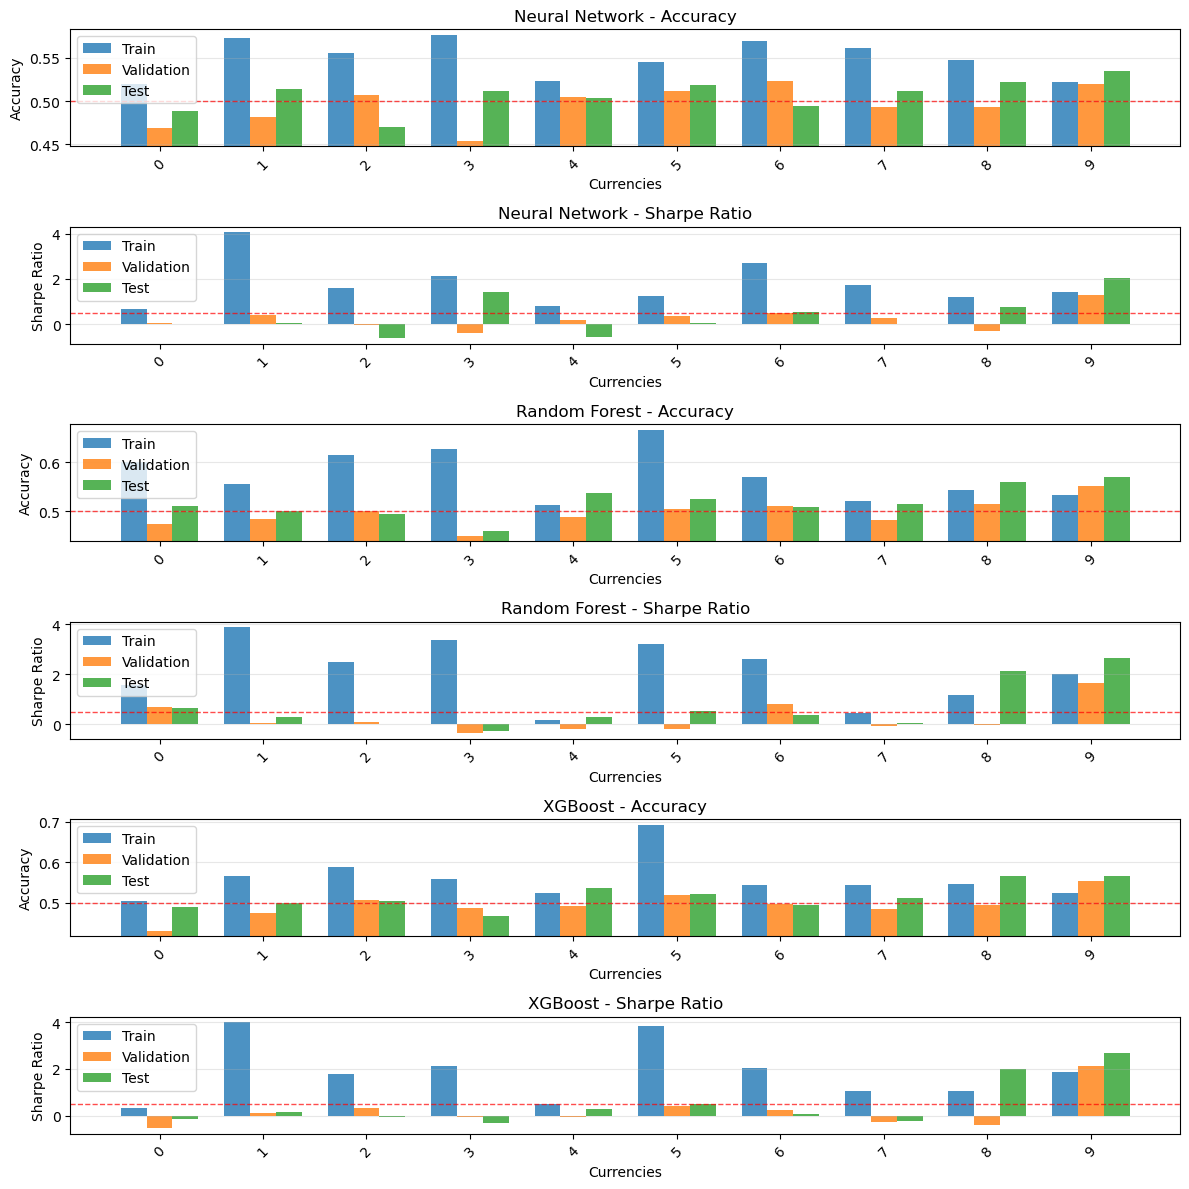

In [59]:
# Sample data structure

# Create 6x1 subplot with bar charts
fig, axes = plt.subplots(6, 1, figsize=(12, 12))

# Setup for grouped bars
x = np.arange(len(currencies))
width = 0.25

# Helper function to create bar chart
def create_bar_chart(ax, train_data, val_data, test_data, title, ylabel, scale_to_data=False):
   bars1 = ax.bar(x - width, train_data, width, label='Train', alpha=0.8)
   bars2 = ax.bar(x, val_data, width, label='Validation', alpha=0.8)
   bars3 = ax.bar(x + width, test_data, width, label='Test', alpha=0.8)
   
   # Add horizontal line at 0.5
   ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, linewidth=1)
   
   if scale_to_data:
       # Set y-axis limits based on data range
       all_data = list(train_data) + list(val_data) + list(test_data)
       y_min = min(all_data)
       y_max = max(all_data)
       margin = (y_max - y_min) * 0.05  # 5% margin
       ax.set_ylim(y_min - margin, y_max + margin)
   
   ax.set_xlabel('Currencies')
   ax.set_ylabel(ylabel)
   ax.set_title(title)
   ax.set_xticks(x)
   ax.set_xticklabels(currencies, rotation=45)
   ax.legend()
   ax.grid(axis='y', alpha=0.3)

# Neural Network charts
create_bar_chart(axes[0], 
               accuracy_results_nn['Train_Accuracy'], 
               accuracy_results_nn['Validation_Accuracy'], 
               accuracy_results_nn['Test_Accuracy'],
               'Neural Network - Accuracy', 'Accuracy', scale_to_data=True)

create_bar_chart(axes[1], 
               accuracy_results_nn['SR_train'], 
               accuracy_results_nn['SR_val'], 
               accuracy_results_nn['SR_test'],
               'Neural Network - Sharpe Ratio', 'Sharpe Ratio')

# Random Forest charts
create_bar_chart(axes[2], 
               accuracy_results_rf['Train_Accuracy'], 
               accuracy_results_rf['Validation_Accuracy'], 
               accuracy_results_rf['Test_Accuracy'],
               'Random Forest - Accuracy', 'Accuracy', scale_to_data=True)

create_bar_chart(axes[3], 
               accuracy_results_rf['SR_train'], 
               accuracy_results_rf['SR_val'], 
               accuracy_results_rf['SR_test'],
               'Random Forest - Sharpe Ratio', 'Sharpe Ratio')

# XGBoost charts
create_bar_chart(axes[4], 
               accuracy_results_xgb['Train_Accuracy'], 
               accuracy_results_xgb['Validation_Accuracy'], 
               accuracy_results_xgb['Test_Accuracy'],
               'XGBoost - Accuracy', 'Accuracy', scale_to_data=True)

create_bar_chart(axes[5], 
               accuracy_results_xgb['SR_train'], 
               accuracy_results_xgb['SR_val'], 
               accuracy_results_xgb['SR_test'],
               'XGBoost - Sharpe Ratio', 'Sharpe Ratio')

plt.tight_layout()
plt.show()

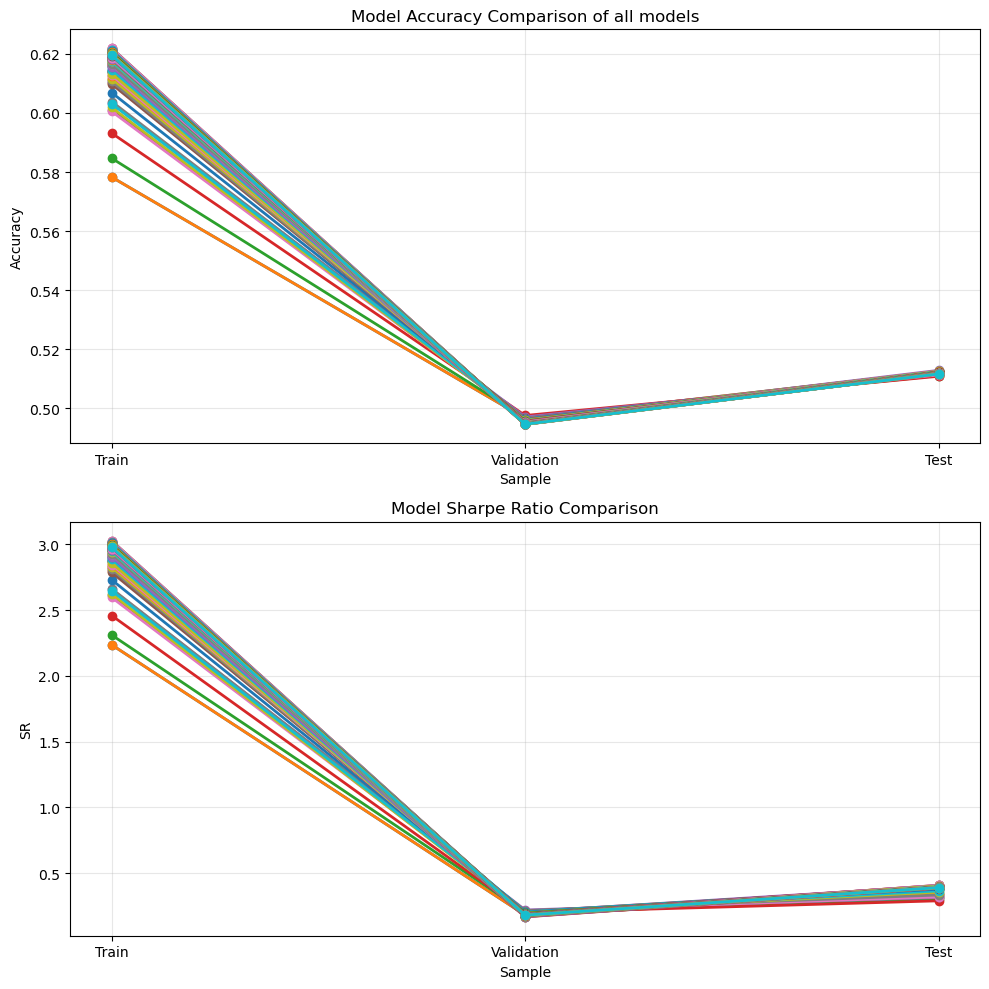

In [71]:
#Plot of accuracy and sharpe ratio of Random Forest models with manual selection

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

x_categories = ['Train', 'Validation', 'Test']
x_positions = range(len(x_categories))

# Left chart - Accuracy
for idx, row in model_choice_accuracy_rfm.iterrows():
    y_values = [row['train_accuracy_mean'], row['val_accuracy_mean'], row['test_accuracy_mean']]
    ax1.plot(x_positions, y_values, marker='o', label=f'Model {row["model_id"]}', linewidth=2, markersize=6)
ax1.set_xlabel('Sample')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison of all models')
ax1.set_xticks(x_positions)
ax1.set_xticklabels(x_categories)
#ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #hide legend
ax1.grid(True, alpha=0.3)

# Right plot - Sharpe Ratio
for idx, row in model_choice_accuracy_rfm.iterrows():
   y_values = [row['SR_train'], row['SR_val'], row['SR_test']]
   ax2.plot(x_positions, y_values, marker='o', label=f'Model {row["model_id"]}', linewidth=2, markersize=6)

ax2.set_xlabel('Sample')
ax2.set_ylabel('SR')
ax2.set_title('Model Sharpe Ratio Comparison')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(x_categories)
#ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left') #hide legend
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
